In [1]:
import copy
import torch
torch.manual_seed(48)
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import IterableDataset, Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(48)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [2]:
class SplitMNIST(IterableDataset):
    def __init__(self, classes_per_split=2, task_duration=1000, root="./data", download=True):
        self.root = root
        self.transform = transforms.ToTensor()
        self.download = download
        self.dataset = datasets.MNIST(root=self.root, train=True, download=self.download)
        self.classes_per_split = classes_per_split
        self.buckets = self.create_buckets()
        self.task_duration = task_duration

    def create_buckets(self):
        # Create buckets of samples with classes_per_split classes in each bucket
        classes = np.unique(self.dataset.targets.numpy())
        # check if classes_per_split is a divisor of the number of classes
        if len(classes) % self.classes_per_split != 0:
            raise ValueError(f"Number of classes {len(classes)} is not divisible by classes_per_split {self.classes_per_split}")
        num_buckets = len(classes) // self.classes_per_split
        buckets = []
        for i in range(num_buckets):
            start = i * self.classes_per_split
            end = start + self.classes_per_split
            bucket_classes = classes[start:end]
            bucket_indices = np.isin(self.dataset.targets.numpy(), bucket_classes)
            buckets.append(np.where(bucket_indices)[0])
        return buckets
    
    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.buckets) * self.task_duration

    def __iter__(self):
        for current_bucket in range(len(self.buckets)):
            for _ in range(self.task_duration):
                bucket = self.buckets[current_bucket]
                idx = np.random.choice(bucket)
                img, target = self.dataset[idx]
                img = self.transform(img)
                target = torch.tensor(target, dtype=torch.long)
                task_id = torch.tensor(current_bucket, dtype=torch.long)
                yield img, target, task_id


In [3]:
train_dataset = SplitMNIST(task_duration=10000)
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=train_dataset.transform, target_transform=torch.tensor)

In [4]:
class GateAutoencoder(nn.Module):
    def __init__(self, in_out_shape=(3,32,32),  depth=3, ff_depth=3, conv_hidden_dim=64, hidden_dim=128, latent_dim=128):
        super(GateAutoencoder, self).__init__()
        self.input_features = in_out_shape[0]
        self.depth = depth
        self.ff_depth = ff_depth
        self.hidden_dim = hidden_dim
        self.conv_hidden_dim = conv_hidden_dim
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()
        latent_width, latent_height = in_out_shape[1] // (2**depth), in_out_shape[2] // (2**depth)
        self.encoder.append(nn.Conv2d(self.input_features, conv_hidden_dim, kernel_size=3, padding=1, padding_mode='reflect'))
        for i in range(depth):
            self.encoder.append(nn.Conv2d(conv_hidden_dim, conv_hidden_dim, kernel_size=4, padding=1, stride=2, padding_mode='reflect'))
            self.encoder.append(nn.BatchNorm2d(conv_hidden_dim))
            self.encoder.append(nn.ReLU())
        self.encoder.append(nn.Flatten())
        for i in range(ff_depth):
            if i == 0:
                in_features = conv_hidden_dim * latent_width * latent_height
            else:
                in_features = hidden_dim
            if i == ff_depth - 1:
                out_features = latent_dim
            else:
                out_features = hidden_dim
            self.encoder.append(nn.Linear(in_features, out_features))
            self.encoder.append(nn.BatchNorm1d(out_features))
            if i != ff_depth - 1:
                self.encoder.append(nn.ReLU())
            else:
                self.encoder.append(nn.Tanh())

        for i in range(ff_depth):
            if i == 0:
                in_features = latent_dim
            else:
                in_features = hidden_dim
            if i == ff_depth - 1:
                out_features = conv_hidden_dim * latent_width * latent_height
            else:
                out_features = hidden_dim
            self.decoder.append(nn.Linear(in_features, out_features))
            self.decoder.append(nn.BatchNorm1d(out_features))
            self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Unflatten(1, (conv_hidden_dim, latent_width, latent_height)))

        for i in range(depth):
            self.decoder.append(nn.ConvTranspose2d(conv_hidden_dim, conv_hidden_dim, kernel_size=4, padding=1, stride=2))
            self.decoder.append(nn.BatchNorm2d(conv_hidden_dim))
            self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Conv2d(conv_hidden_dim, self.input_features, kernel_size=3, padding=1, padding_mode='reflect'))
        self.decoder.append(nn.Sigmoid())

    def forward(self, x: torch.Tensor):
        if self.training:
            x = x + torch.randn_like(x) * 0.1
        latent = self.encoder(x)
        x = self.decoder(latent)
        return x, latent

In [5]:
class ExpertMLP(nn.Module):
	def __init__(self, input_feature: int, depth: int, hidden_features: int, output_features: int):
		super(ExpertMLP, self).__init__()
		
		self.model = nn.Sequential()
		for i in range(depth):
			in_features = input_feature if i == 0 else hidden_features
			out_features = hidden_features
			self.model.append(nn.Linear(in_features, out_features))
			self.model.append(nn.BatchNorm1d(out_features))
			self.model.append(nn.ReLU())
		self.model.append(nn.Linear(hidden_features, output_features))

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		return self.model(x)
	

In [6]:
class GatedExpert(nn.Module):
    def __init__(self, in_out_shape=(1, 28, 28), classes=10, depth=2, ff_depth=3, expert_depth=3, hidden_dim=64, latent_dim=128):
        super(GatedExpert, self).__init__()
        self.gates = nn.ModuleList()
        self.experts = nn.ModuleList()
        self.gate_optimizers = []
        self.expert_optimizers = []
        self.in_out_shape = in_out_shape
        self.classes = classes
        self.depth = depth
        self.ff_depth = ff_depth
        self.expert_depth = expert_depth
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.selection_softmax = nn.Softmax(dim=0)
        self.gate_loss = nn.L1Loss(reduction='none')
        self.expert_loss = nn.CrossEntropyLoss()
        self.new_task_boost = 100

        self.error_window = []
        self.error_window_size = 64
        self.error_window_sum = 0

        self.error_std_threshold = 5
        self.error_flat_threshold = 0.01

        self.fine_tune = False

        self.new_task()

    def add_error(self, error) -> tuple[float, float]:
        if len(self.error_window) >= self.error_window_size:
            self.error_window_sum -= self.error_window.pop(0)
        self.error_window.append(error)
        self.error_window_sum += error
        mean = self.error_window_sum / len(self.error_window)
        std = (sum((error - mean) ** 2 for error in self.error_window) / len(self.error_window)) ** 0.5
        return mean, std

    def reset_error_window(self):
        self.error_window = []
        self.error_window_sum = 0

    def new_task(self):
        self.time_since_new_task = 0
        gate = copy.deepcopy(self.gates[-1]) if len(self.gates) > 0 and self.fine_tune else GateAutoencoder(
            in_out_shape=self.in_out_shape,
            depth=self.depth,
            ff_depth=self.ff_depth,
            conv_hidden_dim=self.hidden_dim,
            hidden_dim=self.hidden_dim * 16,
            latent_dim=self.latent_dim
        )
        self.gates.append(gate)
        expert = copy.deepcopy(self.experts[-1]) if len(self.experts) > 0 and self.fine_tune else ExpertMLP(
            input_feature=self.latent_dim,
            depth=self.expert_depth,
            hidden_features=self.hidden_dim,
            output_features=self.classes
        )
        self.experts.append(expert)
        self.gate_optimizers.append(torch.optim.Adam(gate.parameters(), lr=1e-3))
        self.expert_optimizers.append(torch.optim.Adam(expert.parameters(), lr=1e-3))
        self.reset_error_window()
    
    def forward_gates(self, x: torch.Tensor):
        # x (B, C, H, W)
        latent_representations = []
        reconstructions = []
        reconstruction_errors = []
        for gate in self.gates:
            recon, latent = gate(x)
            latent_representations.append(latent)
            reconstructions.append(recon)
            error = self.gate_loss(recon, x)
            error = error.mean(dim=(1, 2, 3))
            reconstruction_errors.append(error)

        # reconstruction_errors (N_gates, B)
        reconstruction_errors = torch.stack(reconstruction_errors, dim=0)
        reconstructions = torch.stack(reconstructions, dim=0)
        # latent_representations (N_gates, B, latent_dim)
        latent_representations = torch.stack(latent_representations, dim=0)
        return reconstructions, latent_representations, reconstruction_errors

    def forward(self, x: torch.Tensor, mask: torch.Tensor, latent_representations: torch.Tensor):
        # classes (B, classes)
        logits = torch.zeros(x.shape[0], self.classes)
        for i, expert in enumerate(self.experts):
            if torch.all(~mask[i]):
                continue
            expert_input = latent_representations[i][mask[i]]
            expert_output = expert(expert_input)
            logits[mask[i]] = expert_output

        return logits

    def mask_from_recon_errors(self, reconstruction_errors: torch.Tensor):
        last_task_boost = torch.zeros_like(reconstruction_errors)
        if self.training:
            last_task_boost[-1] = self.new_task_boost
        min_reconstruction_errors, indices = torch.min(reconstruction_errors - last_task_boost, dim=0)
        mask = torch.arange(len(self.gates)).unsqueeze(1) == indices.unsqueeze(0)
        return mask, min_reconstruction_errors

    def mask_from_task_ids(self, task_ids: torch.Tensor):
        max_task_id = max(task_ids.max(), len(self.gates) - 1)
        mask = torch.arange(max_task_id + 1).unsqueeze(1) == task_ids.unsqueeze(0)
        return mask

    def predict(self, x: torch.Tensor):
        self.eval()
        with torch.no_grad():
            reconstructions, latent_representations, reconstruction_errors = self.forward_gates(x)
            mask, _ = self.mask_from_recon_errors(reconstruction_errors)
            logits = self.forward(x, mask, latent_representations)
            return logits, reconstructions

    def fit(self, train_dataset: IterableDataset, test_dataset: Dataset | None = None):
        train_loader = DataLoader(train_dataset, batch_size=16)
        if test_dataset is not None:
            test_loader = DataLoader(test_dataset, batch_size=64, generator=torch.Generator(device=device))

        loading_bar = tqdm(train_loader, total=len(train_loader), desc="Training", unit="batch")
        mean, std = 0, 0
        accuracy = 0
        for i, batch in enumerate(loading_bar):
            images, targets, task_ids = batch
            images = images.to(device)
            targets = targets.to(device)

            reconstructions, latent_representations, reconstruction_errors = self.forward_gates(images)
            mask, _ = self.mask_from_recon_errors(reconstruction_errors)
            avg_selected_recon_errors = reconstruction_errors[mask].mean().item()

            if len(self.error_window) == self.error_window_size and avg_selected_recon_errors > mean + self.error_std_threshold * std + self.error_flat_threshold:
                self.new_task()
                reconstructions, latent_representations, reconstruction_errors = self.forward_gates(images)
                mask, _ = self.mask_from_recon_errors(reconstruction_errors)
                avg_selected_recon_errors = reconstruction_errors[mask].mean().item()

            mean, std = self.add_error(avg_selected_recon_errors)

            self.train()
            for j in range(len(self.gates)):
                if mask[j].sum() < 2: # exclude empty batches and single samples to avoid BatchNorm errors
                    continue
                self.gate_optimizers[j].zero_grad()
                self.expert_optimizers[j].zero_grad()
                images_j = images[mask[j]]
                targets_j = targets[mask[j]]
                recon, latent = self.gates[j](images_j)
                expert_output = self.experts[j](latent.detach())
                correct = (expert_output.argmax(dim=1) == targets_j).sum().item()
                total = targets_j.shape[0]
                accuracy = (correct / total) * 0.1 + accuracy * 0.9
                gate_loss = self.gate_loss(recon, images_j).mean()
                expert_loss = self.expert_loss(expert_output, targets_j)
                gate_loss.backward()
                expert_loss.backward()
                self.gate_optimizers[j].step()
                self.expert_optimizers[j].step()
                
            loading_bar.set_postfix({
                #"loss": f"{loss.item():.3f}", 
                "e": f"{expert_loss.item():.3f}", 
                "g": f"{gate_loss.item():.3f}", 
                "n": len(self.gates),
                "mean": f"{mean:.3f}",
                "std": f"{std:.3f}",
                "acc": f"{accuracy:.2%}"})
        if test_dataset is not None:
            self.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                loading_bar = tqdm(test_loader, desc="Testing", total=len(test_loader))
                confusion_matrix = torch.zeros(10, 10, dtype=torch.int64)
                for x, y in loading_bar:
                    x = x.to(device)
                    y = y.to(device)
                    logits, reconstructions = self.predict(x)
                    outputs = logits
                    total += y.shape[0]
                    correct += (outputs.argmax(dim=1) == y).sum().item()
                    accuracy = correct / total
                    confusion_matrix += torch.bincount(y * 10 + outputs.argmax(dim=1), minlength=100).reshape(10, 10)
                    loading_bar.set_postfix(accuracy=f"{accuracy:.2%}")
            return confusion_matrix

In [7]:
model = GatedExpert()

In [8]:
confusion_matrix = model.fit(train_dataset, test_dataset)

Training:   0%|          | 0/3125 [00:00<?, ?batch/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

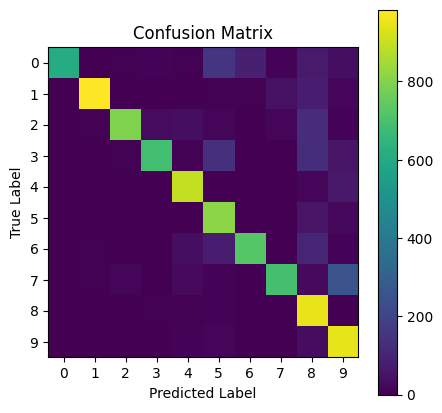

In [9]:
plt.figure(figsize=(5, 5))
plt.imshow(confusion_matrix.cpu(), interpolation='nearest')
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.show()

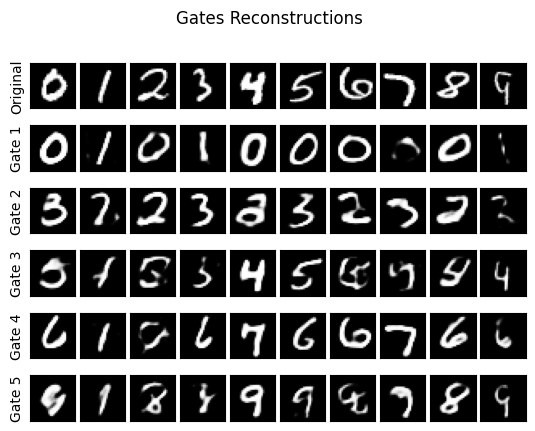

In [10]:
original_images = []
while len(original_images) < 10:
    for i in range(len(test_dataset)):
        img, label = test_dataset[i]
        if label == len(original_images):
            original_images.append((img, label))
original_images = torch.stack([img for img, _ in original_images], dim=0).to(device)
reconstructions = []
for gate in model.gates:
    recon, _ = gate(original_images)
    reconstructions.append(recon)
reconstructions = torch.stack(reconstructions, dim=0)
original_images = original_images.detach().cpu().numpy()
reconstructions = reconstructions.detach().cpu().numpy()
fig, axes = plt.subplots(len(model.gates)+1, 10)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('Gates Reconstructions')
for i in range(10):
    axes[0, i].imshow(original_images[i].transpose(1, 2, 0), cmap='gray')
    if i == 0:
        axes[0, i].set_ylabel('Original')
    axes[0, i].set_yticks([])
    axes[0, i].set_xticks([])
    for j in range(len(model.gates)):
        axes[j + 1, i].imshow(reconstructions[j, i].transpose(1, 2, 0), cmap='gray')
        if i == 0:
            axes[j + 1, i].set_ylabel(f'Gate {j+1}')
        axes[j + 1, i].set_yticks([])
        axes[j + 1, i].set_xticks([])
plt.show()